In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import wandb
from wandb.integration.keras import WandbMetricsLogger

os.environ["KERAS_BACKEND"] = "torch"
import keras
keras.utils.set_random_seed(812)

2024-06-05 20:33:56.642150: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-05 20:33:56.663040: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-05 20:33:57.081189: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: mmgsilva (mmgsilvawb). Use `wandb login --relogin` to force relogin


True

In [3]:
run = wandb.init(
    dir = "../results/syntheticdata/",
    project = "indexes_subsequence_lstm"
)

In [4]:
#create synthetic multivariate time series random uniform integers
n = 1000
k = 10
data = np.random.randint(1, 6, (k, 1000)) #k timeseries of length 1000

data_scenario1 = data.copy()

#select random timewindows of length 5 without overlapping
motif_indexes_scenario1 = []
motif_pattern = [1,1,1,1,1]
p = len(motif_pattern)

max_interval = n//20
print("Max interval between motif", max_interval)
last_index = 0
while True:
    min_interval = p + 20
    index_interval = np.random.randint(min_interval, p + max_interval)
    if last_index + index_interval + p > n:
        break
    last_index = last_index + index_interval
    motif_indexes_scenario1.append(last_index)

print("Planted motifs:", len(motif_indexes_scenario1))

for i in motif_indexes_scenario1:
    for j in range(k):
        data_scenario1[j, i:i+p] = motif_pattern
#save to file as csv
data_csenario1 = data_scenario1.astype(int)
np.savetxt("../data/syntheticdata/scenario1.csv", data_scenario1, delimiter=",")
np.savetxt("../data/syntheticdata/motif_indexes_scenario1.csv", motif_indexes_scenario1, delimiter=",")


Max interval between motif 50
Planted motifs: 24


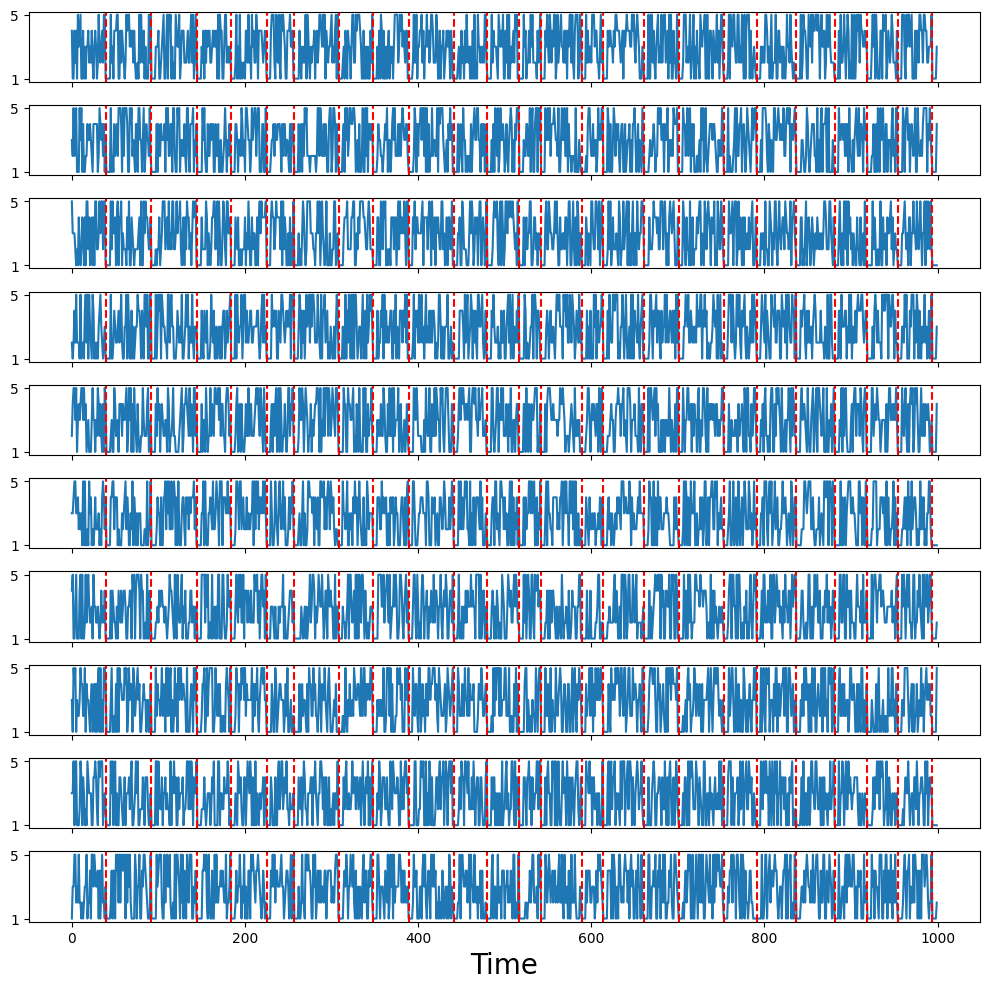

<Figure size 640x480 with 0 Axes>

In [5]:
variable_indexes = np.arange(k)
#change the values of the time series in the selected timewindows to the motif pattern
for idx in motif_indexes_scenario1:
    data[variable_indexes,idx:idx+p] = motif_pattern

#introduce clue in the data
for idx in motif_indexes_scenario1:
    data[variable_indexes,idx-5:idx-2] = [1,2,3]

#plot multivariate data using subplots in red the planted motifs
fig, axis = plt.subplots(nrows=k, ncols=1, figsize=(10, 10), sharex=True)
for i, variable in enumerate(variable_indexes):
 plt.subplot(len(variable_indexes), 1, i+1)
 #y axis from 1 to 5
 plt.yticks([1,5])
 plt.plot(data_scenario1[variable])
 #plot the planted motifs
 for idx in motif_indexes_scenario1:
    plt.axvline(x=idx, color='r', linestyle='--')

plt.xlabel('Time', size=20)
plt.tight_layout()
plt.show()
plt.savefig("../images/data_scenario1.png")

In [6]:

data_scenario2 = data.copy()
interval = 50
print("Interval window", interval)
motif_indexes_scenario2 = []
for i in range(0, n, interval):
    motif_indexes_scenario2.append(np.random.randint(i, i + interval - p))

print("Planted motifs:", len(motif_indexes_scenario2))
for i in motif_indexes_scenario2:
    for j in range(k):
        data_scenario2[j, i:i+p] = motif_pattern
#save to file as csv
data_cenario2 = data_scenario2.astype(int)
np.savetxt("../data/syntheticdata/scenario2.csv", data_scenario2, delimiter=",")
np.savetxt("../data/syntheticdata/motif_indexes_scenario2.csv", motif_indexes_scenario2, delimiter=",")

Interval window 50
Planted motifs: 20


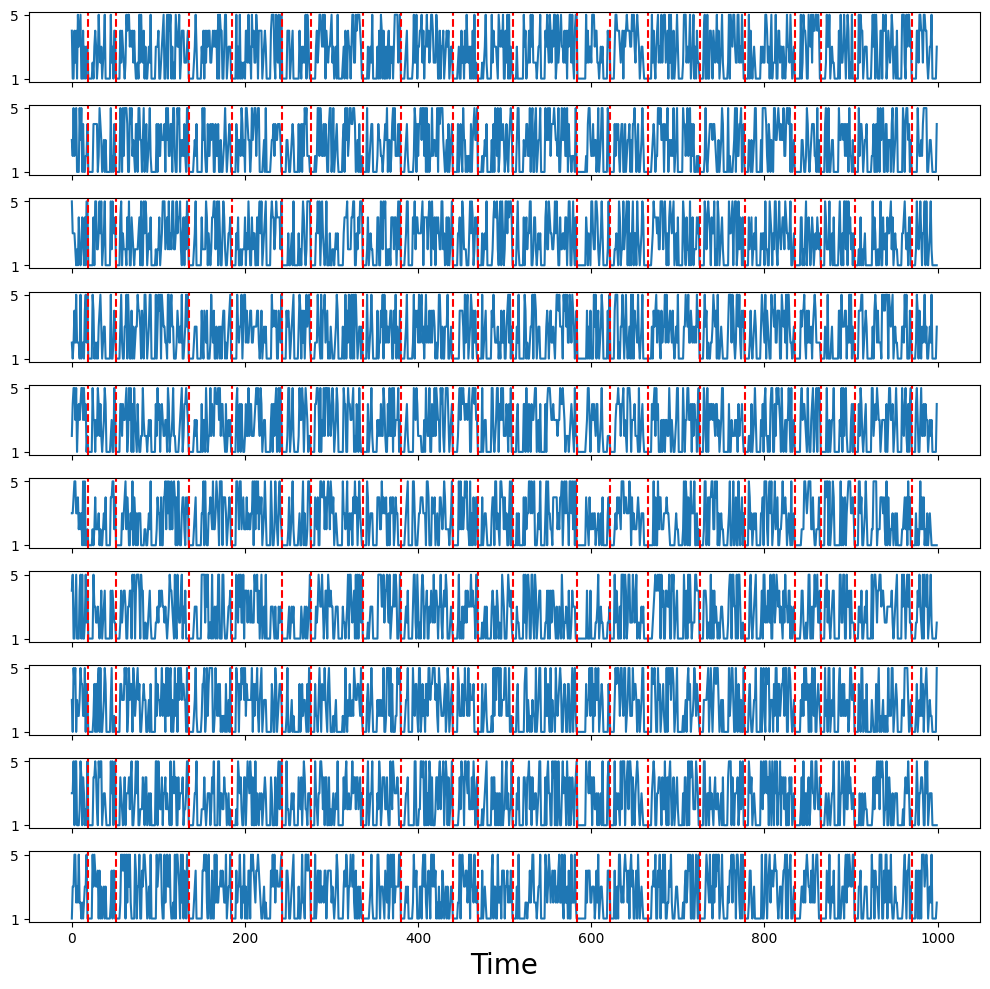

<Figure size 640x480 with 0 Axes>

In [7]:
variable_indexes = np.arange(k)
#change the values of the time series in the selected timewindows to the motif pattern
for idx in motif_indexes_scenario2:
    data[variable_indexes,idx:idx+p] = motif_pattern

#introduce clue in the data
for idx in motif_indexes_scenario2:
    data[variable_indexes,idx-5:idx-2] = [1,2,3]

#plot multivariate data using subplots in red the planted motifs
fig, axis = plt.subplots(nrows=k, ncols=1, figsize=(10, 10), sharex=True)
for i, variable in enumerate(variable_indexes):
 plt.subplot(len(variable_indexes), 1, i+1)
 #y axis from 1 to 5
 plt.yticks([1,5])
 plt.plot(data_cenario2[variable])
 #plot the planted motifs
 for idx in motif_indexes_scenario2:
    plt.axvline(x=idx, color='r', linestyle='--')
plt.xlabel('Time', size=20)
plt.tight_layout()
plt.show()
plt.savefig("../images/data_scenario2.png")

In [ ]:
from keras.preprocessing.sequence import pad_sequences

def create_dataset(data, past_window, step, forward_window, motif_indexes):
    X1, X2, y1, y = list(), list(), list(), list()
    for idx in range(len(data[0]) - past_window - 1):
        if idx % step != 0:
            continue
    
        next_matches = [motif_idx for motif_idx in motif_indexes if motif_idx > idx + past_window]
        if not next_matches:
            continue #no match
        next_match = next_matches[0]
        if next_match > idx + past_window + forward_window:
            next_match = -1 #no match in forward window

        data_x1 = data[variable_indexes,idx:idx+past_window]
        data_x2 = [motif_idx for motif_idx in motif_indexes if motif_idx <= idx+past_window]
        data_y1 = data[variable_indexes, idx+past_window]
        data_y = next_match
        X1.append(data_x1)
        X2.append(data_x2)
        y1.append(data_y1)
        y.append(data_y) 

    X2 = pad_sequences(X2, padding='post', value=-1, dtype=int)
    return np.array(X1), np.array(X2), np.array(y1), np.array(y)

In [ ]:
#load data
data_cenario1 = np.genfromtxt("../data/syntheticdata/randomintervals.csv", delimiter=",")
past_window = 100 #window size
step = 1 #step size for the sliding window
forward_window = 50 #forward window size
#x1: past window, x2: indexes of the motif, y1: next value, y: next index of the motif
X1, X2, y1, y  = create_dataset(data_cenario1, past_window=past_window, step=step, forward_window=forward_window, motif_indexes=motif_indexes)
print(X1[0,0], X2[0], y1[3], y[0])

In [ ]:
# observations, variables, time steps
X1.shape, X2.shape, y1.shape, y.shape

In [ ]:
#reshape input to be [samples, time steps, features]
X1 = np.reshape(X1, (X1.shape[0], X1.shape[2], len(variable_indexes)))
X2 = np.reshape(X2, (X2.shape[0], X2.shape[1], 1))

In [ ]:
class BlockingTimeSeriesSplit():
  def __init__(self, n_splits):
      self.n_splits = n_splits

  def get_n_splits(self, X, y, groups):
      return self.n_splits

  def split(self, X, y=None, groups=None):
      n_samples = len(X)
      k_fold_size = n_samples // self.n_splits
      indices = np.arange(n_samples)

      margin = 0
      for i in range(self.n_splits):
          start = i * k_fold_size
          stop = start + k_fold_size
          mid = int(0.8 * (stop - start)) + start
          yield indices[start: mid], indices[mid + margin: stop]

In [ ]:
#train lstm
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import LSTM, Dense, Masking
from keras import Input

import keras_tuner as kt

class MyHyperModel(kt.HyperModel):

    def __init__(self, input_shape):
        self.input_shape = input_shape

    def build(self, hp):
        model = Sequential()
        model.add(Input(shape=self.input_shape))
        model.add(Masking(mask_value=-1))
        units = hp.Int('units', min_value=10, max_value=50, step=10)
        model.add(LSTM(units=units, activation='relu', return_sequences=False))
        model.add(Dense(1))
        hp_learning_rate = hp.Choice('learning_rate', values=[1e-3, 1e-4, 1e-5])
        model.compile(loss='mse', optimizer=Adam(learning_rate=hp_learning_rate), metrics=['mae', 'root_mean_squared_error', 'r2_score'])
        return model


In [ ]:
import collections
from keras.callbacks import EarlyStopping
import pickle



class CVTuner(kt.engine.tuner.Tuner):

    def __init__(self, *args, **kwargs):
        super(CVTuner, self).__init__(*args, **kwargs)
        # cols are metrics-val_loss, val_mae, val_rmse, val_r2
        self.metrics_history = []

    def run_trial(self, trial, x, y, *args, **kwargs):
        callbacks = kwargs.pop("callbacks", [])
        callbacks.append(EarlyStopping(patience=10, monitor="val_loss"))
        verbose = kwargs.pop("verbose", 0)
        batch_size = trial.hyperparameters.Choice('batch_size', values=[2,8,16,32,64])

        metrics = collections.defaultdict(list)
        cv = BlockingTimeSeriesSplit(n_splits=5)
        trial_metrics = np.zeros((5, 4), dtype=np.float32)
        for i, (train_indices, test_indices) in enumerate(cv.split(x)):
            #split train indices into train and validation
            mid = int(0.8 * len(train_indices))
            train_indices, val_indices = train_indices[:mid], train_indices[mid:]
            X_train, X_val, X_test = x[train_indices], x[val_indices], x[test_indices]
            y_train, y_val, y_test = y[train_indices], y[val_indices], y[test_indices]
            model = self.hypermodel.build(trial.hyperparameters)
            model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, batch_size=batch_size, verbose=verbose, callbacks=callbacks)
            test_loss, test_mae, test_rmse, test_r2 = model.evaluate(X_test, y_test) 
            metrics["test_loss"].append(test_loss)
            metrics["test_mae"].append(test_mae)
            metrics["test_rmse"].append(test_rmse)
            metrics["test_r2"].append(test_r2)
            #save metrics
            for j, (_, value) in enumerate(metrics.items()):
                trial_metrics[i, j] = value[-1]

        self.metrics_history.append(trial_metrics)
        print({name: np.mean(values) for name, values in metrics.items()})
        #save cross validation metrics
        return {name: np.mean(values) for name, values in metrics.items()}
    
    def save_metrics(self):
        # aggregate metric_history into a matrix (num trials, num folds, num metrics)
        fname = os.path.join(self.project_dir, "metrics_history.npy")
        np.save(fname, np.array(self.metrics_history))
    
    def save_model(self, trial_id, model, step=0):
        fname = os.path.join(self.get_trial_dir(trial_id), "model.pickle")
        with open(fname, "wb") as f:
            pickle.dump(model, f)

    def load_model(self, trial):
        fname = os.path.join(self.get_trial_dir(trial.trial_id), "model.pickle")
        with open(fname, "rb") as f:
            return pickle.load(f)

# tuner = CVTuner(
#   hypermodel=MyHyperModel(input_shape=(X2.shape[1], X2.shape[2])),
#   oracle=kt.oracles.GridSearchOracle(
#     objective=kt.Objective("test_loss", "min"),
#     max_trials=None),
#     directory='../results/syntheticdata',
#     project_name='indexes_subsequence_lstm')

# # each fold 139 train 35 test
# tuner.search(
#         x=X2,
#         y=y,
#         verbose=0,
#         callbacks=[WandbMetricsLogger(log_freq=5)],
#     )
# run.finish()
# tuner.save_metrics()

In [ ]:
# metrics_history = np.array(tuner.metrics_history)
# metrics_history.shape

In [ ]:
# tuner.results_summary()

In [ ]:
# #get config of the best model
# best_trial = tuner.oracle.get_best_trials(1)[0]

# print(best_trial.metrics.get_best_value("test_mae"))
# print(metrics_history[int(tuner.oracle.get_best_trials(1)[0].trial_id)].mean(axis=0))

# #train the best model, using the best hyperparameters
# cv = BlockingTimeSeriesSplit(5)
# metrics = []

# for i, (train_indices, test_indices) in enumerate(cv.split(X2)):
#     mid = int(0.8 * len(train_indices))
#     train_indices, val_indices = train_indices[:mid], train_indices[mid:]
#     X_train, X_val, X_test = X2[train_indices], X2[val_indices], X2[test_indices]
#     y_train, y_val, y_test = y[train_indices], y[val_indices], y[test_indices]
#     model = MyHyperModel().build((best_trial.hyperparameters))
#     model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, batch_size=best_trial.hyperparameters.get("batch_size"), verbose=0, callbacks=EarlyStopping(patience=10, monitor="val_loss"))
#     test_loss, test_mae, test_rmse, test_r2 = model.evaluate(X_test, y_test)
#     metrics.append([test_loss, test_mae, test_rmse, test_r2])

# metrics = np.array(metrics)
# metrics.mean(axis=0)

In [ ]:
from keras.layers import RepeatVector
class MyHyperModel_embeddinglstm(kt.HyperModel):
    def __init__(self, input_shape):
        self.input_shape = input_shape #time steps, features
    
    def build(self, hp):
        model = Sequential()
        model.add(Input(shape=(self.input_shape)))
        model.add(LSTM(units=128,  name='encoder_2', return_sequences=True))
        model.add(LSTM(units=64,  name='encoder_3', return_sequences=False))
        model.add(RepeatVector(self.input_shape[0], name='encoder_decoder_bridge'))
        model.add(LSTM(units=64, name='decoder_1', return_sequences=True))
        model.add(LSTM(units=128,  name='decoder_2', return_sequences=True))
        model.add(keras.layers.TimeDistributed(keras.layers.Dense(self.input_shape[1])))
        hp_learning_rate = hp.Choice('learning_rate', values=[1e-3, 1e-4, 1e-5])
        model.compile(loss='mse', optimizer=Adam(learning_rate=hp_learning_rate), metrics=['mae', 'root_mean_squared_error'])
        return model


tuner = kt.RandomSearch(
    MyHyperModel_embeddinglstm(input_shape=(X1.shape[1], X1.shape[2])),
    objective='loss',  
    max_trials=None,  
    directory='../results/syntheticdata',  
    project_name='embeddinglstm')

tuner.search(X1, X1, epochs=400, shuffle=False,
             callbacks=[WandbMetricsLogger(), EarlyStopping(patience=10, monitor="loss")],
             verbose=1)


In [ ]:
data.shape
#reshape input to be [samples, time steps, features]
X_data = np.reshape(data, (1, data.shape[1], data.shape[0]))

In [ ]:
#train the model in the whole dataset
best_trial = tuner.oracle.get_best_trials(1)[0]
best_model = MyHyperModel_embeddinglstm(input_shape=(data.shape[1], data.shape[0])).build(best_trial.hyperparameters)
best_model.fit(X_data, X_data, epochs=400, verbose=0)
y_pred = best_model.predict(X_data)
y_pred.shape

In [ ]:
y_pred

In [ ]:
#metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
print("MSE:", mean_squared_error(X_data[0], y_pred[0]))
print("MAE:", mean_absolute_error(X_data[0], y_pred[0]))
print("R2:", r2_score(X_data[0], y_pred[0]))

plt.figure()
for i, variable in enumerate(variable_indexes):
    plt.subplot(len(variable_indexes), 1, i+1)
    plt.plot(data[variable], label='original')
    plt.plot(y_pred[0,:,variable], label='predicted')
plt.show()

In [ ]:
#get the weights of the model
weights = best_model.get_layer('embedding_layer').get_weights()
weights[0].shape

In [ ]:
best_model.summary()

In [ ]:
#join the embeddings with the motif indexes
X_train = []
for x2 in X2_train:
    #concat embeddigs with x2
    x2 = x2.flatten()
    x2 = np.concatenate((embeddings, x2))
    X_train.append(x2)

X_train = np.array(X_train)

X_test = []
for x2 in X2_test:
    #concat embeddigs with x2
    x2 = x2.flatten()
    x2 = np.concatenate((embeddings, x2))
    X_test.append(x2)

X_test = np.array(X_test)
X_train.shape


In [ ]:
from xgboost import XGBRegressor

model = XGBRegressor()
model.fit(X_train, y_train)

In [ ]:
#evaluate the model
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

y_train_pred = model.predict(X_train)
mse = mean_squared_error(y_train, y_train_pred)
mae = mean_absolute_error(y_train, y_train_pred)
r2 = r2_score(y_train, y_train_pred)

print(f'MSE: {mse}')
print(f'MAE: {mae}')
print(f'R2: {r2}')

plt.plot(y_train, label='True')
plt.plot(y_train_pred, label='Predicted')

In [ ]:
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'MAE: {mae}')
print(f'R2: {r2}')

plt.plot(y_test, label='True')
plt.plot(y_pred, label='Predicted')


In [ ]:
#join the embeddings with the motif indexes and the motif pattern
X_train = []
for x2 in X2_train:
    #concat embeddigs with x2
    x2 = x2.flatten()
    x2 = np.concatenate((embeddings, x2, motif_pattern))
    X_train.append(x2)

X_train = np.array(X_train)

X_test = []
for x2 in X2_test:
    #concat embeddigs with x2
    x2 = x2.flatten()
    x2 = np.concatenate((embeddings, x2, motif_pattern))
    X_test.append(x2)

X_test = np.array(X_test)
X_train.shape
